## Copyright 2022 Google LLC. Double-click for license information.

In [4]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Null-text inversion + Editing with Prompt-to-Prompt

In [5]:
import os
os.environ["FLAGS_set_to_1d"] = "False"
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import paddle
from ppdiffusers import StableDiffusionPipeline, DDIMScheduler
import paddle.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import seq_aligner
import shutil
from paddle.optimizer.adam import Adam
from PIL import Image
import paddle_add

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.

In [6]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", 
                          clip_sample=False, set_alpha_to_one=False, steps_offset=1)
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = paddle.CUDAPlace(0) if paddle.device.cuda.device_count()>0 else paddle.CPUPlace()
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=scheduler)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

[2023-10-02 10:11:49,066] [    INFO] - Loading configuration file /root/.cache/paddlenlp/ppdiffusers/CompVis/stable-diffusion-v1-4/text_encoder/config.json
[2023-10-02 10:11:49,067] [    INFO] - Model config CLIPTextConfig {
  "_name_or_path": "openai/clip-vit-large-patch14",
  "architectures": [
    "CLIPTextModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "dropout": 0.0,
  "eos_token_id": 2,
  "hidden_act": "quick_gelu",
  "hidden_size": 768,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 77,
  "model_type": "clip_text_model",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "paddlenlp_version": null,
  "projection_dim": 512,
  "return_dict": true,
  "transformers_version": "4.21.0.dev0",
  "vocab_size": 49408
}

[2023-10-02 10:11:52,886] [    INFO] - Loading configuration file /root/.cache/paddlenlp/ppdiffusers/CompVis/stable-diffusion-v1-4/safe

## Prompt-to-Prompt code

In [7]:
class LocalBlend:
    
    def get_mask(self, maps, alpha, use_pool):
        k = 1
        maps = (maps * alpha).sum(-1).mean(1)
        if use_pool:
            maps = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(maps, size=(x_t.shape[2:]))
        # mask = mask / mask.max(2, keepdim=True)[0].max(3, keepdim=True)[0]
        mask = mask / mask.max(2, keepdim=True).max(3, keepdim=True)
        mask = mask.greater_than(paddle.to_tensor(self.th[1-int(use_pool)]))
        mask = paddle_add.add_bool(mask[:1], mask)
        return mask
    
    def __call__(self, x_t, attention_store):
        self.counter += 1
        if self.counter > self.start_blend:
           
            maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
            maps = [item.reshape((self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS)) for item in maps]
            maps = paddle.concat(maps, axis=1)
            mask = self.get_mask(maps, self.alpha_layers, True)
            if self.substruct_layers is not None:
                maps_sub = ~self.get_mask(maps, self.substruct_layers, False)
                mask = mask * maps_sub
            mask = mask.astype("float32")
            x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], substruct_words=None, start_blend=0.2, th=(.3, .3)):
        alpha_layers = paddle.zeros((len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS))
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        
        if substruct_words is not None:
            substruct_layers = paddle.zeros((len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS))
            for i, (prompt, words_) in enumerate(zip(prompts, substruct_words)):
                if type(words_) is str:
                    words_ = [words_]
                for word in words_:
                    ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                    substruct_layers[i, :, :, :, :, ind] = 1
            self.substruct_layers = substruct_layers.cuda()
        else:
            self.substruct_layers = None
        self.alpha_layers = alpha_layers.cuda()
        self.start_blend = int(start_blend * NUM_DDIM_STEPS)
        self.counter = 0 
        self.th=th


        
        
class EmptyControl:
    
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn

    
class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class SpatialReplace(EmptyControl):
    
    def step_callback(self, x_t):
        if self.cur_step < self.stop_inject:
            b = x_t.shape[0]
            x_t = x_t[:1].expand((b, *x_t.shape[1:]))
        return x_t

    def __init__(self, stop_inject: float):
        super(SpatialReplace, self).__init__()
        self.stop_inject = int((1 - stop_inject) * NUM_DDIM_STEPS)
        

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

        
class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace, place_in_unet):
        if att_replace.shape[2] <= 32 ** 2:
            attn_base = attn_base.unsqueeze(0).expand((att_replace.shape[0], *attn_base.shape))
            return attn_base
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape((self.batch_size, h, *attn.shape[1:]))
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce, place_in_unet)
            attn = attn.reshape((self.batch_size * h, *attn.shape[2:]))
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).cuda()
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return paddle.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).cuda()
        

class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        # attn_base_replace = attn_base[:, :, self.mapper].transpose((2, 0, 1, 3))
        index = self.mapper.flatten()
        tmp_select = paddle.index_select(attn_base, index, axis=2) 
        attn_base_replace = tmp_select.reshape((attn_base.shape[0], attn_base.shape[1], *self.mapper.shape)) \
                .transpose((2, 0, 1, 3))
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.cuda(), alphas.cuda()
        self.alphas = alphas.reshape((alphas.shape[0], 1, 1, alphas.shape[1]))


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.cuda()
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = paddle.ones((1, 77))
    
    for word, val in zip(word_select, values):
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape((len(prompts), -1, res, res, item.shape[-1]))[select]
                out.append(cross_maps)
    out = paddle.concat(out, axis=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])["input_ids"]
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand((*image.shape, 3))
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))
    

def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape((res, res))
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))


## Null Text Inversion code

In [8]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


class NullInversion:
    
    def prev_step(self, model_output: Union[paddle.Tensor, np.ndarray], timestep: int, sample: Union[paddle.Tensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    def next_step(self, model_output: Union[paddle.Tensor, np.ndarray], timestep: int, sample: Union[paddle.Tensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = paddle.concat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @paddle.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clip(0, 1)
            image = image.cpu().transpose(perm=(0, 2, 3, 1)).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @paddle.no_grad()
    def image2latent(self, image):
        with paddle.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is paddle.Tensor and image.dim() == 4:
                latents = image
            else:
                image = paddle.to_tensor(image, dtype=paddle.get_default_dtype()) / 127.5 - 1
                image = image.transpose(perm=(2, 0, 1)).unsqueeze(0)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @paddle.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pd"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids)[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pd",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids)[0]
        self.context = paddle.concat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @paddle.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @paddle.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    def null_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.stop_gradient = False
            optimizer = Adam(parameters=[uncond_embeddings], learning_rate=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with paddle.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.clear_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with paddle.no_grad():
                context = paddle.concat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return uncond_embeddings_list
    
    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings
        
    
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False, steps_offset=1)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None

null_inversion = NullInversion(ldm_stable)

## Inference Code

In [9]:
@paddle.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    # generator: Optional[torch.Generator] = None,
    generator: Optional[object] = None,
    latent: Optional[paddle.Tensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    ptp_utils.register_attention_control(model, controller)
    height = width = 512
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pd",
    )
    text_embeddings = model.text_encoder(text_input.input_ids)[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pd"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids)[0]
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = paddle.concat([uncond_embeddings[i].expand(text_embeddings.shape), text_embeddings])
        else:
            context = paddle.concat([uncond_embeddings_, text_embeddings])
        latents = ptp_utils.diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent



def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

In [10]:
image_path = "./example_images/gnochi_mirror.jpeg"
prompt = "a cat sitting next to a mirror"
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

Modify or remove offsets according to your image!


/nfs/github/recurrent/prompt-to-prompt_pp/ptp_utils.py:98: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand((batch_size,  model.unet.in_channels, height // 8, width // 8))


  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image


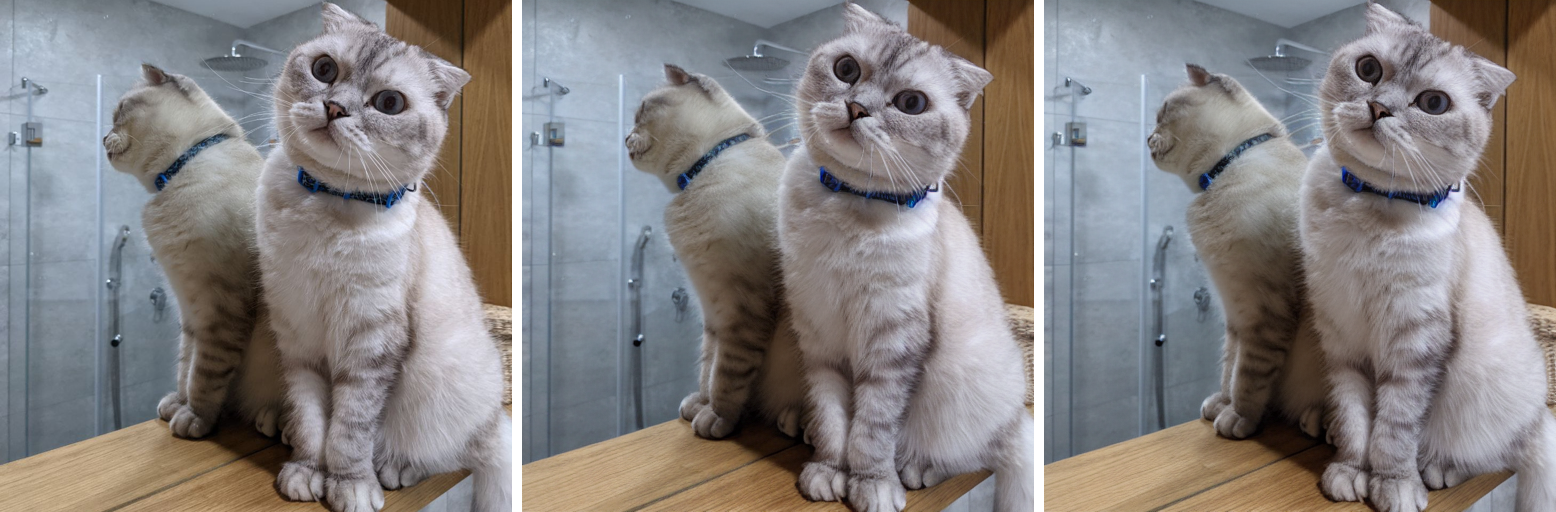

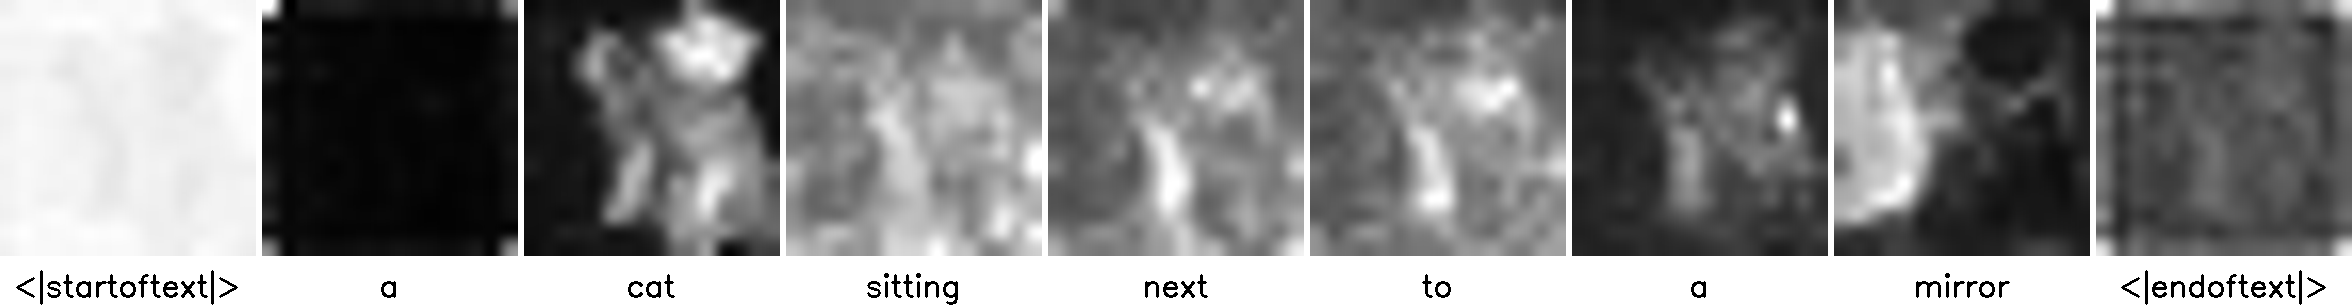

In [11]:
prompts = [prompt]
controller = AttentionStore()
image_inv, x_t = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings, verbose=False)
print("showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image")
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
show_cross_attention(controller, 16, ["up", "down"])


In [12]:
prompts = ["a cat sitting next to a mirror",
           "a tiger sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('cat',), ("tiger",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("tiger",), "values": (2,)} # amplify attention to the word "tiger" by *2 

controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")

  0%|          | 0/50 [00:00<?, ?it/s]

SystemError: (Fatal) Operator set_value raises an paddle::memory::allocation::BadAlloc exception.
The exception content is
:

--------------------------------------
C++ Traceback (most recent call last):
--------------------------------------
0   set_value__dygraph_function(paddle::Tensor&, paddle::Tensor const&, std::vector<paddle::Tensor, std::allocator<paddle::Tensor> > const&, std::vector<paddle::Tensor, std::allocator<paddle::Tensor> > const&, std::vector<paddle::Tensor, std::allocator<paddle::Tensor> > const&, paddle::framework::AttributeMap const&)
1   paddle::imperative::Tracer::TraceOp(std::string const&, paddle::imperative::NameTensorMap const&, paddle::imperative::NameTensorMap const&, paddle::framework::AttributeMap&, phi::Place const&, paddle::framework::AttributeMap*, bool, std::map<std::string, std::string, std::less<std::string >, std::allocator<std::pair<std::string const, std::string > > > const&)
2   void paddle::imperative::Tracer::TraceOpImpl<egr::EagerVariable>(std::string const&, paddle::imperative::details::NameVarMapTrait<egr::EagerVariable>::Type const&, paddle::imperative::details::NameVarMapTrait<egr::EagerVariable>::Type const&, paddle::framework::AttributeMap&, phi::Place const&, bool, std::map<std::string, std::string, std::less<std::string >, std::allocator<std::pair<std::string const, std::string > > > const&, paddle::framework::AttributeMap*, bool)
3   paddle::imperative::PreparedOp::Run(paddle::imperative::NameTensorMap const&, paddle::imperative::NameTensorMap const&, paddle::framework::AttributeMap const&, paddle::framework::AttributeMap const&)
4   phi::KernelImpl<void (*)(phi::GPUContext const&, phi::DenseTensor const&, phi::DenseTensor const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, phi::DenseTensor*), &(void phi::SetTensorValueKernel<float, phi::GPUContext>(phi::GPUContext const&, phi::DenseTensor const&, phi::DenseTensor const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, phi::DenseTensor*))>::Compute(phi::KernelContext*)
5   void phi::SetTensorValueKernel<float, phi::GPUContext>(phi::GPUContext const&, phi::DenseTensor const&, phi::DenseTensor const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, phi::DenseTensor*)
6   void phi::SetValueImpl<float, phi::GPUContext, 4ul>(phi::GPUContext const&, phi::DenseTensor const&, phi::DenseTensor const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, std::vector<long, std::allocator<long> > const&, phi::DenseTensor*)
7   phi::DenseTensor phi::Empty<float, phi::GPUContext>(phi::GPUContext const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&)
8   void phi::EmptyKernel<float, phi::GPUContext>(phi::GPUContext const&, paddle::experimental::IntArrayBase<phi::DenseTensor> const&, phi::DataType, phi::DenseTensor*)
9   float* phi::DeviceContext::Alloc<float>(phi::TensorBase*, unsigned long, bool) const
10  phi::DeviceContext::Impl::Alloc(phi::TensorBase*, phi::Place const&, phi::DataType, unsigned long, bool, bool) const
11  phi::DenseTensor::AllocateFrom(phi::Allocator*, phi::DataType, unsigned long, bool)
12  paddle::memory::allocation::Allocator::Allocate(unsigned long)
13  paddle::memory::allocation::StatAllocator::AllocateImpl(unsigned long)
14  paddle::memory::allocation::Allocator::Allocate(unsigned long)
15  paddle::memory::allocation::Allocator::Allocate(unsigned long)
16  paddle::memory::allocation::Allocator::Allocate(unsigned long)
17  paddle::memory::allocation::CUDAAllocator::AllocateImpl(unsigned long)
18  std::string phi::enforce::GetCompleteTraceBackString<std::string >(std::string&&, char const*, int)
19  phi::enforce::GetCurrentTraceBackString[abi:cxx11](bool)

----------------------
Error Message Summary:
----------------------
ResourceExhaustedError: 

Out of memory error on GPU 0. Cannot allocate 1.000000GB memory on GPU 0, 21.699402GB memory has been allocated and available memory is only 295.562500MB.

Please check whether there is any other process using GPU 0.
1. If yes, please stop them, or start PaddlePaddle on another GPU.
2. If no, please decrease the batch size of your model. 
 (at ../paddle/fluid/memory/allocation/cuda_allocator.cc:86)
. (at ../paddle/fluid/imperative/tracer.cc:322)


In [ ]:
prompts = ["a cat sitting next to a mirror",
           "a silver cat sculpture sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8, }
self_replace_steps = .6
blend_word = ((('cat',), ("cat",))) # for local edit
eq_params = {"words": ("silver", 'sculpture', ), "values": (2,2,)}  # amplify attention to the words "silver" and "sculpture" by *2 
 
controller = make_controller(prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)


In [ ]:
prompts = ["a cat sitting next to a mirror",
           "watercolor painting of a cat sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8, }
self_replace_steps = .7
blend_word = None
eq_params = {"words": ("watercolor",  ), "values": (5, 2,)}  # amplify attention to the word "watercolor" by 5
 
controller = make_controller(prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)